In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.python.keras.engine.training import _is_scalar
import pandas_datareader as web
import datetime

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
# Load Data
# company = 'FB'  # ticker symbol
company = input('Input the Ticker Symbol of a Company: ')

start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2021, 1, 1)

data = web.DataReader(company, 'yahoo', start, end)

Input the Ticker Symbol of a Company: AAPL


In [3]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.629209
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.697079
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.838044
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.972249
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.951672
...,...,...,...,...,...,...
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.549637
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.254608
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.440399


In [67]:
# Preprocess Data
scalar = MinMaxScaler(feature_range=(0, 1))
scaled_data = scalar.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 1000

X_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    X_train.append(scaled_data[x - prediction_days:x-10, 0])
    y_train.append(scaled_data[x-10:x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [68]:
y_train

array([[0.12186081, 0.12298103, 0.11689105, ..., 0.10232804, 0.10497586,
        0.10477219],
       [0.12298103, 0.11689105, 0.11546531, ..., 0.10497586, 0.10477219,
        0.10758295],
       [0.11689105, 0.11546531, 0.11141209, ..., 0.10477219, 0.10758295,
        0.10640161],
       ...,
       [0.87852616, 0.92822368, 0.92765338, ..., 0.95331694, 0.9615455 ,
        1.        ],
       [0.92822368, 0.92765338, 0.93490433, ..., 0.9615455 , 1.        ,
        0.98517215],
       [0.92765338, 0.93490433, 0.91828422, ..., 1.        , 0.98517215,
        0.97580299]])

In [69]:
# Build the Model
model = Sequential()

model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=256))
model.add(Dropout(0.2))
model.add(Dense(units=10))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
40/40 [==============================] - 10s 172ms/step - loss: 0.0653
Epoch 2/25
40/40 [==============================] - 7s 173ms/step - loss: 0.0031
Epoch 3/25
40/40 [==============================] - 7s 174ms/step - loss: 0.0027
Epoch 4/25
40/40 [==============================] - 7s 175ms/step - loss: 0.0034
Epoch 5/25
40/40 [==============================] - 7s 176ms/step - loss: 0.0025
Epoch 6/25
40/40 [==============================] - 7s 176ms/step - loss: 0.0022
Epoch 7/25
40/40 [==============================] - 7s 174ms/step - loss: 0.0022
Epoch 8/25
40/40 [==============================] - 7s 173ms/step - loss: 0.0022
Epoch 9/25
40/40 [==============================] - 7s 173ms/step - loss: 0.0024
Epoch 10/25
40/40 [==============================] - 7s 172ms/step - loss: 0.0020
Epoch 11/25
40/40 [==============================] - 7s 172ms/step - loss: 0.0019
Epoch 12/25
40/40 [==============================] - 7s 172ms/step - loss: 0.0018
Epoch 13/25
40/40 [=====

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 990, 256)          264192    
_________________________________________________________________
dropout_3 (Dropout)          (None, 990, 256)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 990, 256)          525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 990, 256)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

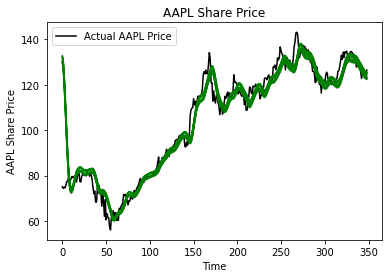

In [71]:
#### Test the Model Accuracy on Existing Data ####
test_start = datetime.datetime(2020, 1, 1)
test_end = datetime.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)


model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scalar.transform(model_inputs)

# Make Prediction on Test Data
X_test = []

for x in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[x-prediction_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scalar.inverse_transform(predicted_prices)

# Plot the Test Predictions
plt.plot(actual_prices, color='black', label=f'Actual {company} Price')
# plt.plot(predicted_prices, color='green', label=f'Predicted {company} Price')
plt.plot(predicted_prices, color='green')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [72]:
all = np.append(actual_prices[-90:], prediction[0]) 

In [73]:
# Predict Next Day
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scalar.inverse_transform(prediction)
print(f'Prediction: {prediction[0][0]}')

Prediction: 122.9945068359375


In [74]:
prediction[0]

array([122.99451 , 124.973595, 123.11524 , 123.7176  , 122.354706,
       125.26495 , 125.557915, 122.947845, 124.37366 , 125.17438 ],
      dtype=float32)

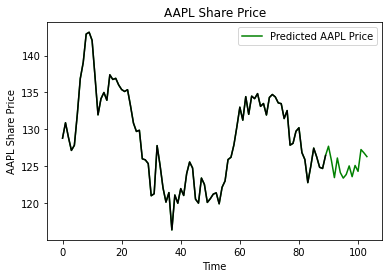

In [75]:
plt.plot(all, color='green', label=f'Predicted {company} Price')
plt.plot(actual_prices[-90:], color='black')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()